In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision
from torchvision.transforms.functional import crop, resize
import matplotlib.pyplot as plt

In [14]:
import os

def flatten(lst):
    res=[]
    for i in lst:
        if isinstance(i, list) or isinstance(i, tuple):
            res.extend(flatten(i))
        else:
            res.append(i)
    return res

# Calculate max-chrominance? 
# Cr - Cb plot

def findAllFiles(path):
    res = []
    path, folders, files = next(os.walk(path))
    if folders:
        for f in folders:
            res.extend(findAllFiles(os.path.join(path, f)))
    res.extend([os.path.join(path, f) for f in files])
    return res

In [15]:
import numpy as np

In [16]:
raw_folder = "../../raw-instinct/16bitRAW"
classes    = os.listdir(raw_folder)
raw_data   = [(c,[np.load(f).astype(np.int32)
                  for f in findAllFiles(os.path.join(raw_folder, c))]) 
              for c in classes]

In [17]:
def sparse_ones(shape, coords):
    t = torch.zeros(*shape)
    for coor in coords:
        t[coor] = 1.0

    return t

bayer_k = sparse_ones((4,1,2,2), [(0,0,0,1),(1,0,0,0),(2,0,1,0),(3,0,1,1)])
rgb_k   = sparse_ones((4,3,2,2), [(0,0,0,1),(1,1,0,0),(2,2,1,0),(3,1,1,1)])
g_int_k = sparse_ones((3,3,3,3), [(1,1,0,1),(1,1,1,0),(1,1,1,2),(1,1,2,1)]) * 0.25
cr_k    = sparse_ones((2,3,2,2), [(1,1,1,0),(0,0,1,0)])
cb_k    = sparse_ones((2,3,2,2), [(1,1,0,1),(0,2,0,1)])

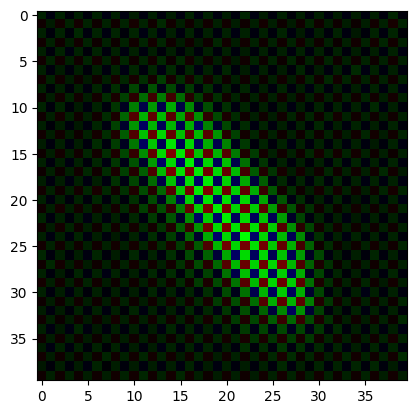

In [25]:
test_tensor = torch.Tensor(test).unsqueeze(0)
test_conv   = F.conv2d(          test_tensor, stride=2, weight=bayer_k, padding=1)
test_rgb    = F.conv_transpose2d(test_conv,   stride=2, weight=rgb_k,   padding=1)
plt.imshow((test_rgb / test_rgb.max()).permute(1,2,0))
plt.show()

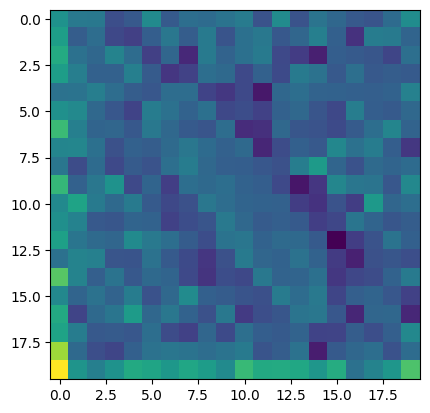

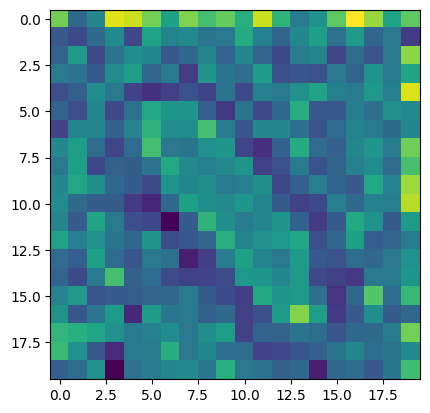

0.5234518647193909 0.4057725667953491


In [27]:
def chroma(mat):
    tensor = torch.Tensor(mat).unsqueeze(0)
    
    conv   = F.conv2d(          tensor, stride=2, weight=bayer_k, padding=1)
    rgb    = F.conv_transpose2d(conv,   stride=2, weight=rgb_k,   padding=1)
    bi_g   = F.conv2d(          rgb,              weight=g_int_k, padding=1) + rgb
    
    cr_l   = F.conv2d(          bi_g,   stride=2, weight=cr_k)
    cb_l   = F.conv2d(          bi_g,   stride=2, weight=cb_k)

    cr     = (cr_l[0] / cr_l[1])
    cb     = (cb_l[0] / cb_l[1])

    return cr, cb

def chromaMean(mat):
    cr, cb = chroma(mat)
    return torch.mean(cr).item(), torch.mean(cb).item()

test = raw_data[0][1][0]

cr, cb = chroma(test)

plt.imshow((cr / cr.max()))
plt.show()
plt.imshow((cb / cb.max()))
plt.show()
print(torch.mean(cr).item(), torch.mean(cb).item())

In [215]:
raw_chroma = [(c, np.array([chromaMean(m) for m in lst])) for (c, lst) in raw_data]

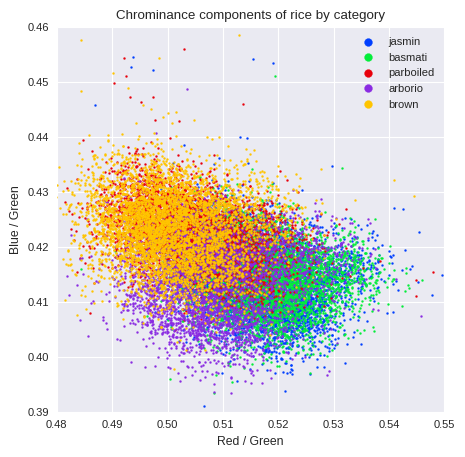

In [262]:

plt.style.use("seaborn-v0_8-darkgrid")
fig = plt.figure(figsize=(5,5))
ax  = plt.gca()
ax.set_title("Chrominance components of rice by category")
ax.set_ylim([0.39, 0.46])
ax.set_xlim([0.48,  0.55])
ax.set_xlabel("Red / Green")
ax.set_ylabel("Blue / Green")
for (c, lst) in raw_chroma:
    ax.scatter(*lst.T, s=2, label=c)

ax.legend(markerscale=4)

In [1]:
def demosaic_ahd(raw):
    fir_h = torch.Tensor([-0.25, 0.5, 0.5, 0.5, -0.25])
    mono  = torch.Tensor([1, 0, 1])

    tensor = torch.Tensor(mat).unsqueeze(0)
    
    conv   = F.conv2d(          tensor, stride=2, weight=bayer_k, padding=1)
    convT  = F.conv_transpose2d(conv,   stride=2, weight=rgb_k,   padding=1)
    
    # Interpolate green
    rgb_v = F.conv2d(convT, weight=fir_h,   padding=(1,0))
    rgb_h = F.conv2d(convT, weight=fir_h.T, padding=(0,1))

    # Median filter green
    # bi linear interpolation of red and blue
    # CIElab convertion
    # Homogeneity map generation
    # Blur homogeneity maps
    # combine vertical and horzontal images

SyntaxError: invalid syntax (215104516.py, line 5)

In [2]:
ex = (test_rgb / test_rgb.max()).permute(1,2,0)

NameError: name 'test_rgb' is not defined

In [76]:
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *

# Dual conversion
cfa_img = np.array(raw_data[0][1][0], dtype=np.uint16)
# RawTherapee won't open a square image 
# with dimensions smaller then 225x225
cfa_img = np.zeros((225,225)).astype(np.uint16)
height, width = cfa_img.shape

bpp = 16

# uncalibrated color matrix, just for demo. 
ccm1 = [[19549, 10000], [-7877, 10000], [-2582, 10000],	
        [-5724, 10000], [10121, 10000], [1917, 10000],
        [-1267, 10000], [ -110, 10000], [ 6621, 10000]]

# set DNG tags.
t = DNGTags()
t.set(Tag.ImageWidth, width)
t.set(Tag.ImageLength, height)
t.set(Tag.TileWidth, width)
t.set(Tag.TileLength, height)
t.set(Tag.Orientation, Orientation.Horizontal)
t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
t.set(Tag.SamplesPerPixel, 1)
t.set(Tag.BitsPerSample, bpp)
t.set(Tag.CFARepeatPatternDim, [2,2])
t.set(Tag.CFAPattern, CFAPattern.GRBG)
t.set(Tag.BlackLevel, (4096 >> (16 - bpp)))
t.set(Tag.WhiteLevel, ((1 << bpp) -1) )
t.set(Tag.ColorMatrix1, ccm1)
t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65)
t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]])
t.set(Tag.BaselineExposure, [[-150,100]])
t.set(Tag.Make, "Camera Brand")
t.set(Tag.Model, "Camera Model")
t.set(Tag.DNGVersion, DNGVersion.V1_4)
t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

# save to dng file.
r = RAW2DNG()
r.options(t, path="", compress=False)
r.convert(cfa_img, filename="custom")

'custom.dng'

In [85]:
218*218

47524

In [46]:
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *
import numpy as np
import struct

# image specs
width = 4096
height = 3072
bpp= 12

# load raw data into 16-bit numpy array.
numPixels = width*height
rawFile = 'scene_daylight_211ms_c2.raw16'
rf = open(rawFile, mode='rb')
rawData = struct.unpack("H"*numPixels,rf.read(2*numPixels))
rawFlatImage = np.zeros(numPixels, dtype=np.uint16)
rawFlatImage[:] = rawData[:] 
rawImage = np.reshape(rawFlatImage,(height,width))
rawImage = rawImage >> (16 - bpp)

# uncalibrated color matrix, just for demo. 
ccm1 = [[19549, 10000], [-7877, 10000], [-2582, 10000],	
        [-5724, 10000], [10121, 10000], [1917, 10000],
        [-1267, 10000], [ -110, 10000], [ 6621, 10000]]

# set DNG tags.
t = DNGTags()
t.set(Tag.ImageWidth, width)
t.set(Tag.ImageLength, height)
t.set(Tag.TileWidth, width)
t.set(Tag.TileLength, height)
t.set(Tag.Orientation, Orientation.Horizontal)
t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
t.set(Tag.SamplesPerPixel, 1)
t.set(Tag.BitsPerSample, bpp)
t.set(Tag.CFARepeatPatternDim, [2,2])
t.set(Tag.CFAPattern, CFAPattern.GBRG)
t.set(Tag.BlackLevel, (4096 >> (16 - bpp)))
t.set(Tag.WhiteLevel, ((1 << bpp) -1) )
t.set(Tag.ColorMatrix1, ccm1)
t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65)
t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]])
t.set(Tag.BaselineExposure, [[-150,100]])
t.set(Tag.Make, "Camera Brand")
t.set(Tag.Model, "Camera Model")
t.set(Tag.DNGVersion, DNGVersion.V1_4)
t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

# save to dng file.
r = RAW2DNG()
r.options(t, path="", compress=False)
r.convert(rawImage, filename="custom")

'custom.dng'

In [53]:
rawImage, rawImage.shape, cfa_img, cfa_img.shape, np.zeros((1000,1000))

(array([[1745, 1304, 1679, ..., 1104, 1453, 1166],
        [1605, 1790, 1588, ..., 1383, 1348, 1541],
        [1718, 1323, 1705, ...,  981, 1371, 1125],
        ...,
        [1305, 1171, 1284, ...,  269,  331,  301],
        [1109,  786, 1215, ...,  222,  309,  274],
        [1221, 1115, 1214, ...,  267,  308,  301]], dtype=uint16),
 (3072, 4096),
 array([[336, 148, 331, ..., 126, 364, 108],
        [153, 269, 183, ..., 325, 224, 340],
        [315, 100, 331, ..., 137, 356,  65],
        ...,
        [184, 287, 156, ..., 322, 186, 431],
        [228,  96, 293, ..., 124, 276, 145],
        [145, 314, 157, ..., 297, 183, 299]], dtype=uint16),
 (40, 40),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))